# LSTM Notebook
##### Perform Regression on Dividend Data using an LSTM based network
##### Aim to predict next value in sequence

In [30]:
# Importing the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.transforms import Bbox
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, InputLayer
from keras.optimizers import SGD
from keras.utils import plot_model
import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [31]:
# Load Ticker data from GetTickers.ipynb
kept_status = np.load("../data/numpy/kept_status.npy")
lost_status = np.load("../data/numpy/lost_status.npy")
lost_status_date = np.load("../data/numpy/lost_status_date.npy",allow_pickle=True)

In [32]:
# MSE Function
def MSE(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))
    
# Split Dataframe into train and test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]


In [33]:
# Collect list of all companies we have data for

# Get list of file names
fileList = os.listdir("../data/series/good")

# Loop through file names and collect ticker symbols
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName not in [".DS",".ipynb"]:
        companyList.append(companyName)
print(companyList)

['VFC', 'KMB', 'NC', 'GWW', 'SJW', 'SEIC', 'EGN', 'NDSN', 'RLI', 'MATW', 'MCD', 'CLX', 'PG', 'UMBF', 'MMM', 'ROST', 'AFL', 'ABT', 'T', 'EXPD', 'CHD', 'BDX', 'GRC', 'FFMR', 'CTAS', 'PII', 'JNJ', 'CBU', 'BKH', 'LANC', 'NUE', 'WTRG', 'WABC', 'BANF', 'ECL', 'CPKF', 'SKT', 'MGEE', 'BEN', 'TGT', 'NEE', 'FLIC', 'CWT', 'TRI', 'CSL', 'NNN', 'ABM', 'CFR', 'SON', 'SRCE', 'CSVI', 'CINF', 'SPGI', 'AWR', 'O', 'IBM', 'WEYS', 'MSA', 'ESS', 'CBSH', 'NJR', 'BOH', 'LOW', 'TFX', 'CVX', 'EFSI', 'PBI', 'TR', 'ALB', 'EMR', 'AROW', 'TMP', 'MCY', 'LEG', 'ED', 'KO', 'NIDB', 'DOV', 'PH', 'ORI', 'FUL', 'TDS', 'WRE', 'MKC', 'FRT', 'PSBQ', 'GPC', 'MO', 'BMS', 'TNC', 'ENB', 'ITW', 'CTBI', 'BRO', 'AOS', 'PEP', 'ATR', 'UBSI', 'NFG', 'SHW', 'MDU', 'SCL', 'ROP', 'UGI', 'ARTNA', 'MGRC', 'WGL', 'MDT', 'CNI', 'LECO', 'TROW', 'RPM', 'ERIE', 'HRL', 'SWK', 'CB', 'ADM', 'APD', 'LIN', 'BMI', 'UHT', 'FMCB', 'ADP', 'CAT', 'SBSI', 'PNR', 'RTX', 'EBTC', 'NWN', 'OZK', 'JKHY', 'PPG', 'DBD', 'ATO', 'GD', 'WST', 'CL', 'WBA', 'TYCB', 'S

In [34]:
# Add to ignore list if no data is available
# Yahoo Finance will occasionally not through error
# for some companies during GetMetrics, which end up creating blank
# csvs that we can simply ignore here
ignoreList = ["FFMR","FMCB"]
stockList = list(set(companyList).difference(ignoreList))

# Load and store data in initial Dataframe
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("../data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])

# Create new Dataframe that contains data for each company
# split at specified year
df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2006", "0")

In [35]:
# Scale the data
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range = (0,1)) # normalize values to be within [0,1]
    train = df_new[i]["Train"].values
    test = df_new[i]["Test"].values
    
    train = np.expand_dims(train, axis = 1)
    test = np.expand_dims(test, axis = 1)
    transform_train[i] = sc.fit_transform(train)
    transform_test[i] = sc.fit_transform(test)
    # Save scalers for predictions at later step
    scaler[i] = sc

# Free up memory
del train
del test

In [36]:
# Dynamically determine which samples have enough information to be trained
# Need every dataset to have a similar length for training/testing

train_lengths = [data.shape[0] for data in transform_train.values()] 
val, ct = np.unique(np.array(train_lengths), return_counts=True)
train_count = val[np.argsort(ct)][-1]

test_lengths = [data.shape[0] for data in transform_test.values()] 
val, ct = np.unique(np.array(test_lengths), return_counts=True)
test_count = val[np.argsort(ct)][-1]

In [37]:
# train_count -= 20
# test_count -= 20
train_count, test_count

(80, 60)

In [38]:
# Determine how many samples will used for prediction
# this will use the previous 5 samples
overlap = 5

trainset = {}
testset = {}

stockListFix = [] # This will contain stocks that have enough samples to be included in training
testDates = {} # collect dates of test samples for later visualizations

# Created data structure for input sets and expected outputs
# Created by sliding window of len overlap across datasets
for j in stockList:
        if transform_train[j].shape[0] < train_count or transform_test[j].shape[0] < test_count:
            continue
        stockListFix.append(j)
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(overlap,train_count):
            X_train.append(transform_train[j][i-overlap:i,0])
            y_train.append(transform_train[j][i,0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.expand_dims(X_train, axis=len(X_train.shape))
        trainset[j]["y"] = y_train

        testset[j] = {}
        X_test = []
        y_test = []   
        testDates[j] = []
        for i in range(overlap, test_count):
            X_test.append(transform_test[j][i-overlap:i,0])
            y_test.append(transform_test[j][i,0])
            testDates[j].append(df_new[j]['Test'].index[i])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.expand_dims(X_test, axis=len(X_test.shape))
        testset[j]["y"] = y_test

In [39]:
# Visualize dataset shapes for each company
arr_buff = []
for i in stockListFix:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockListFix)

,X_train,y_train,X_test,y_test
CLX,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
CINF,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
ADP,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
EMR,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
AROW,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
...,...,...,...,...
MDT,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
VFC,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
HP,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
APD,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"


/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


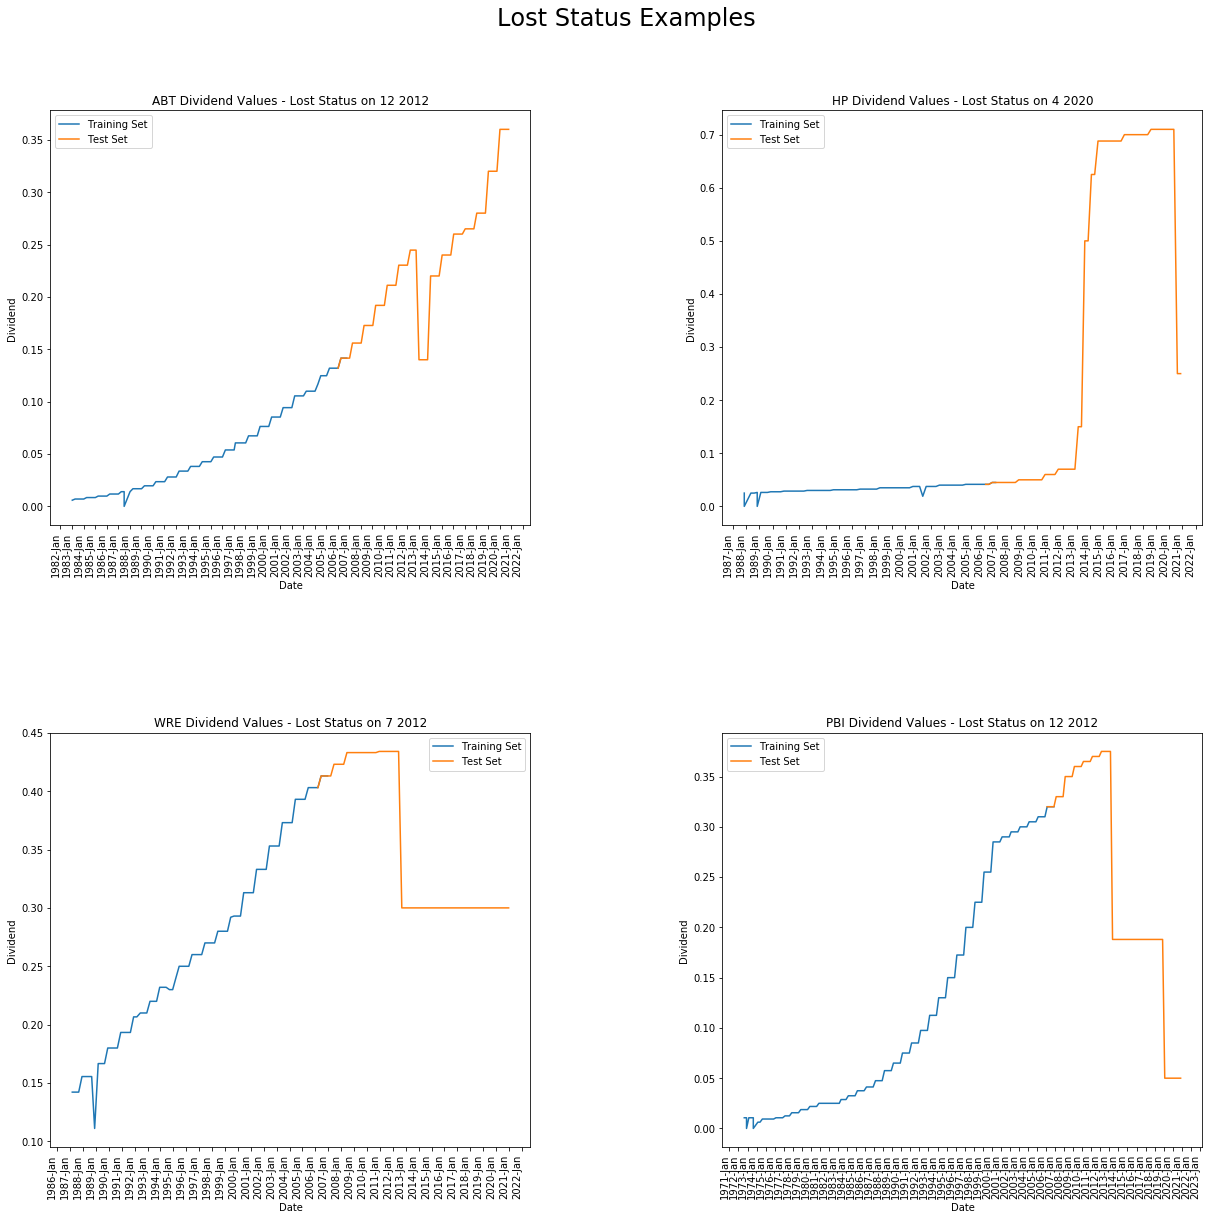

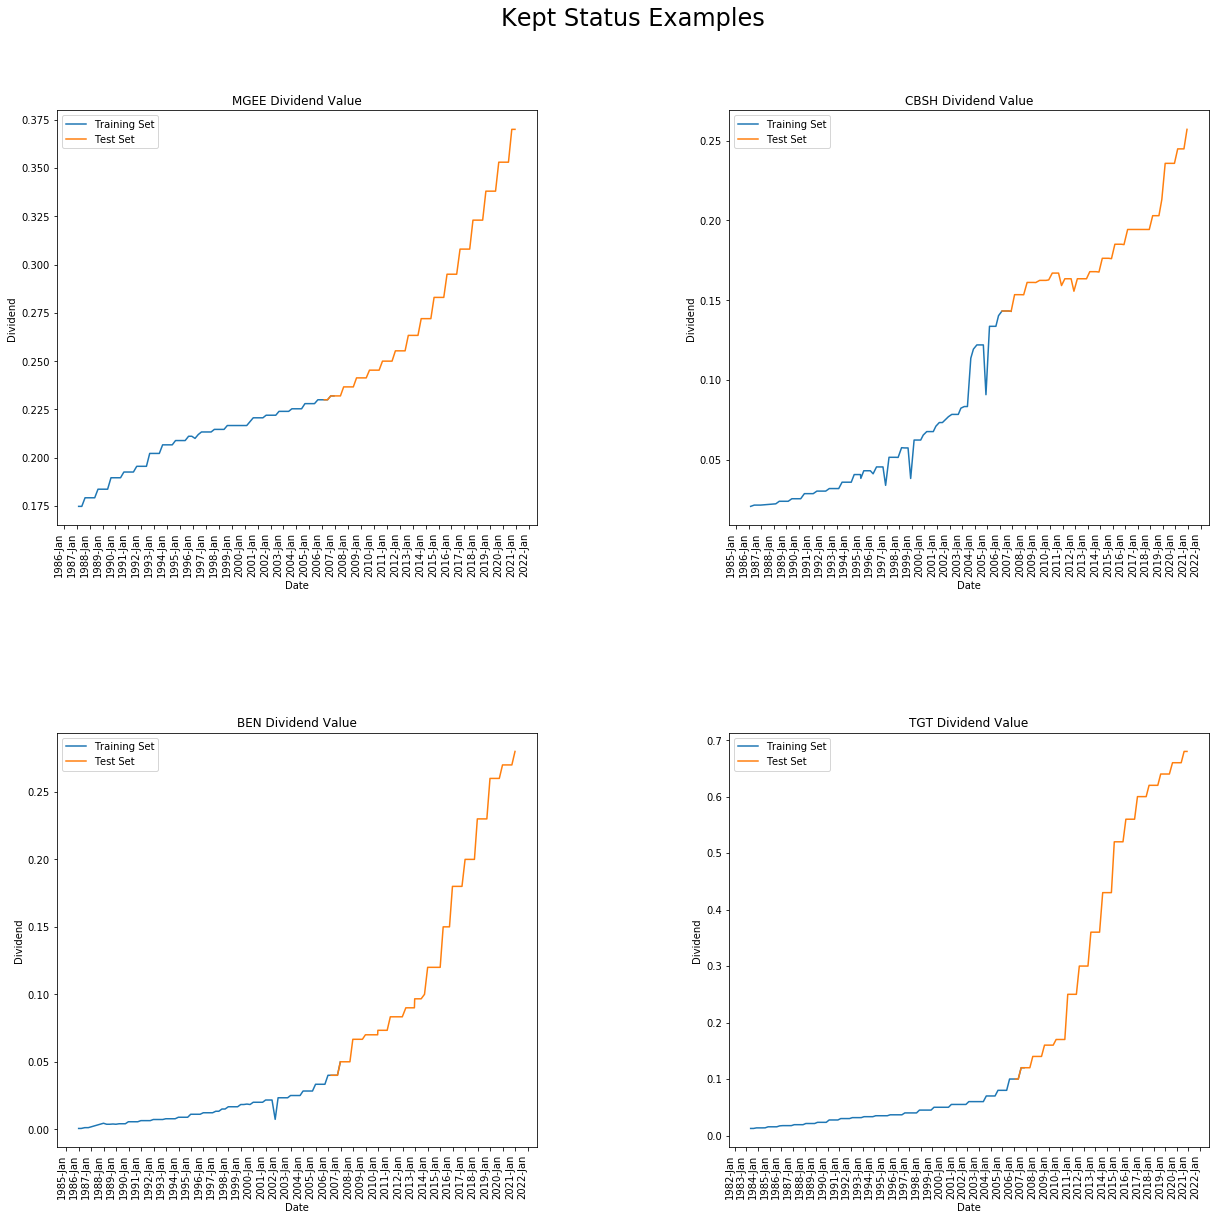

In [40]:
# Plot Examples From Dataset

randidx = np.random.permutation(len(stockList))
shufStockList = np.array(stockList)[randidx]

lost_ct = 0
kept_ct = 0

lost_figs = ["PBI","ABT","WRE","HP"]
kept_figs = ["MGEE","TGT","BEN","CBSH"]

lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))
lost_fig.suptitle("Lost Status Examples", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

for i in shufStockList:
    if df_new[i]["Train"].empty or df_new[i]["Test"].empty:
        print(f"No Data For {i}, add to ignoreList and rerun cells")
    if i in stockListFix and i in lost_figs and lost_ct <= 3:
        indx = lost_ct
        axs = lost_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#         axs.xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_new[i]["Train"].index, df_new[i]["Train"].values)
        axs[indx].plot(df_new[i]["Test"].index,df_new[i]["Test"].values)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Training Set", "Test Set"])  
        dateIdx = [i in lost_status_date[:,2][j] for j in range(len(lost_status_date))]
        date = lost_status_date[dateIdx][0][:2]        
        axs[indx].set_title(i + f" Dividend Values - Lost Status on {date[1]} {date[0]}")  
        extent = axs[indx].get_window_extent().transformed(lost_fig.dpi_scale_trans.inverted())
        lost_fig.savefig(f"./images/{i}_Dataset.png", format="png", bbox_inches=extent.expanded(1.3, 1.35))        
        
        lost_ct += 1
        
    if i in stockListFix and i in kept_figs and  kept_ct <= 3:
        indx = kept_ct
        axs = kept_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#         axs.xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_new[i]["Train"].index, df_new[i]["Train"].values)
        axs[indx].plot(df_new[i]["Test"].index,df_new[i]["Test"].values)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Training Set", "Test Set"])
        axs[indx].set_title(i + " Dividend Value") 
        extent = axs[indx].get_window_extent().transformed(kept_fig.dpi_scale_trans.inverted())
        kept_fig.savefig(f"./images/{i}_Dataset.png", format="png", bbox_inches=extent.expanded(1.3, 1.35))     
        kept_ct += 1
        

plt.show()

#### NOTE: Some companies in the "lost status" category could have lost status without their being a significant dip in their historical dividend values. For this project, we are focusing on attempting to predict the next dividend value even if it has a sudden decline.

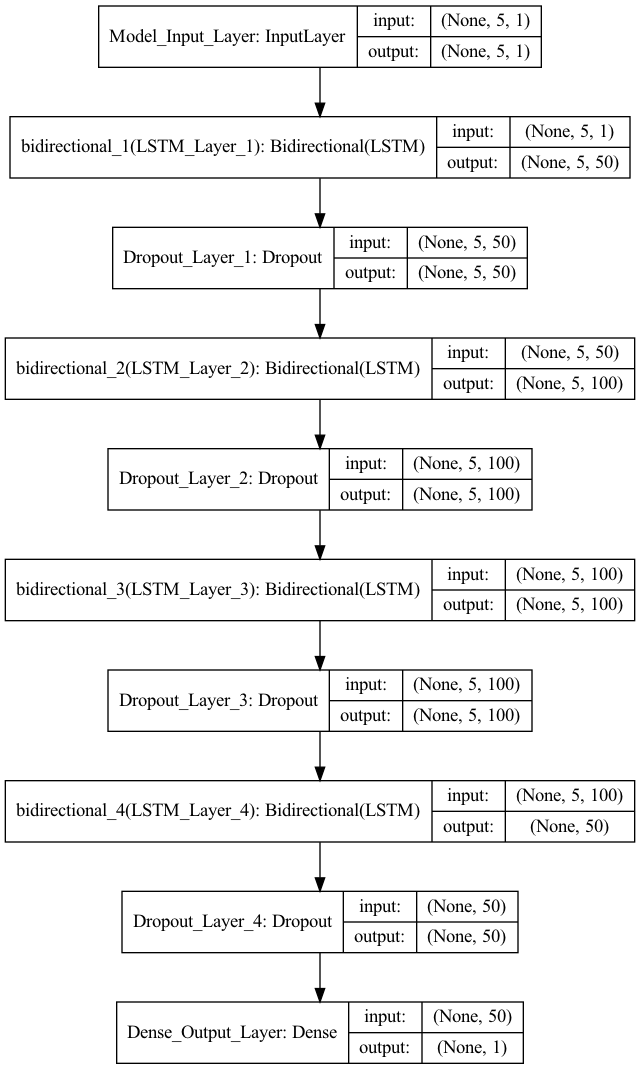

In [12]:
# Create LSTM Model

# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularization
regressor.add(InputLayer(input_shape=(X_train.shape[1],1), name = "Model_Input_Layer"))
regressor.add(Bidirectional(LSTM(units=25, return_sequences=True, name="LSTM_Layer_1")))
regressor.add(Dropout(0.2,name="Dropout_Layer_1"))
# Second LSTM layer
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True,name="LSTM_Layer_2")))
regressor.add(Dropout(0.3,name="Dropout_Layer_2"))
# Third LSTM layer
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True,name="LSTM_Layer_3")))
regressor.add(Dropout(0.4,name="Dropout_Layer_3"))
# Fourth LSTM layer
regressor.add(Bidirectional(LSTM(units=25, return_sequences=False,name="LSTM_Layer_4")))
regressor.add(Dropout(0.5,name="Dropout_Layer_4"))
# The output layer
regressor.add(Dense(units=1, name="Dense_Output_Layer")) 

plot_model(
    regressor,
    to_file="./images/model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

In [13]:
%%time
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
hists = {}
for i in stockListFix:
    print("Fitting to", i)
    hists[i] = regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=40,verbose=0)

Fitting to CLX

Fitting to CINF
Fitting to ADP
Fitting to EMR
Fitting to AROW
Fitting to ABM
Fitting to HRL
Fitting to WMT
Fitting to GPC
Fitting to MKC
Fitting to TNC
Fitting to DCI
Fitting to UBSI
Fitting to UHT
Fitting to ORI
Fitting to CWT
Fitting to NDSN
Fitting to NEE
Fitting to RPM
Fitting to MCD
Fitting to BRO
Fitting to PPG
Fitting to GWW
Fitting to WEYS
Fitting to SHW
Fitting to SPGI
Fitting to WST
Fitting to O
Fitting to AFL
Fitting to NUE
Fitting to BOH
Fitting to FUL
Fitting to BKH
Fitting to TDS
Fitting to TGT
Fitting to MMM
Fitting to TR
Fitting to SRCE
Fitting to SYY
Fitting to NJR
Fitting to IBM
Fitting to UMBF
Fitting to WTRG
Fitting to TROW
Fitting to KO
Fitting to CSL
Fitting to DOV
Fitting to UVV
Fitting to SWK
Fitting to FRT
Fitting to RLI
Fitting to PG
Fitting to LANC
Fitting to BEN
Fitting to MDU
Fitting to T
Fitting to UGI
Fitting to WBA
Fitting to PH
Fitting to GRC
Fitting to ITW
Fitting to PBI
Fitting to LOW
Fitting to ADM
Fitting to MO
Fitting to WRE
Fitting

In [ ]:
# Plot Prediction Results with MSE

pred_result = {}

lost_ct = 0
kept_ct = 0


lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))        
lost_fig.suptitle("Lost Status Examples With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)


kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

for i in stockListFix:
    # if i in shufStockList:
        y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
        y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
        mse = mean_squared_error(y_true, y_pred)
        pred_result[i] = {}
        pred_result[i]["True"] = y_true
        pred_result[i]["Pred"] = y_pred
        
        

        if i in lost_figs and lost_ct <= 3:
            
            np.save(f"../data/numpy/{i}_pred_lstm", y_pred)
            
            indx = lost_ct
            axs = lost_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
            axs[indx].plot(pd.DatetimeIndex(testDates[i]), y_true)
            axs[indx].plot(pd.DatetimeIndex(testDates[i]),y_pred)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Predicted"])
            axs[indx].set_title("{} with MSE {:10.4f}".format(i,mse))
            extent = axs[indx].get_window_extent().transformed(lost_fig.dpi_scale_trans.inverted())
            lost_fig.savefig(f"./images/{i}_Prediction.png", format="png", bbox_inches=extent.expanded(1.3, 1.35)) 
            lost_ct += 1

        if i in kept_figs and kept_ct <= 3:
            
            np.save(f"../data/numpy/{i}_pred_lstm", y_pred)
            
            indx = kept_ct
            axs = kept_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
            axs[indx].plot(pd.DatetimeIndex(testDates[i]), y_true)
            axs[indx].plot(pd.DatetimeIndex(testDates[i]),y_pred)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Predicted"])
            axs[indx].set_title("{} with MSE {:10.6f}".format(i,mse))
            extent = axs[indx].get_window_extent().transformed(kept_fig.dpi_scale_trans.inverted())
            kept_fig.savefig(f"./images/{i}_Prediction.png", format="png", bbox_inches=extent.expanded(1.3, 1.35))     
            kept_ct += 1

plt.show()

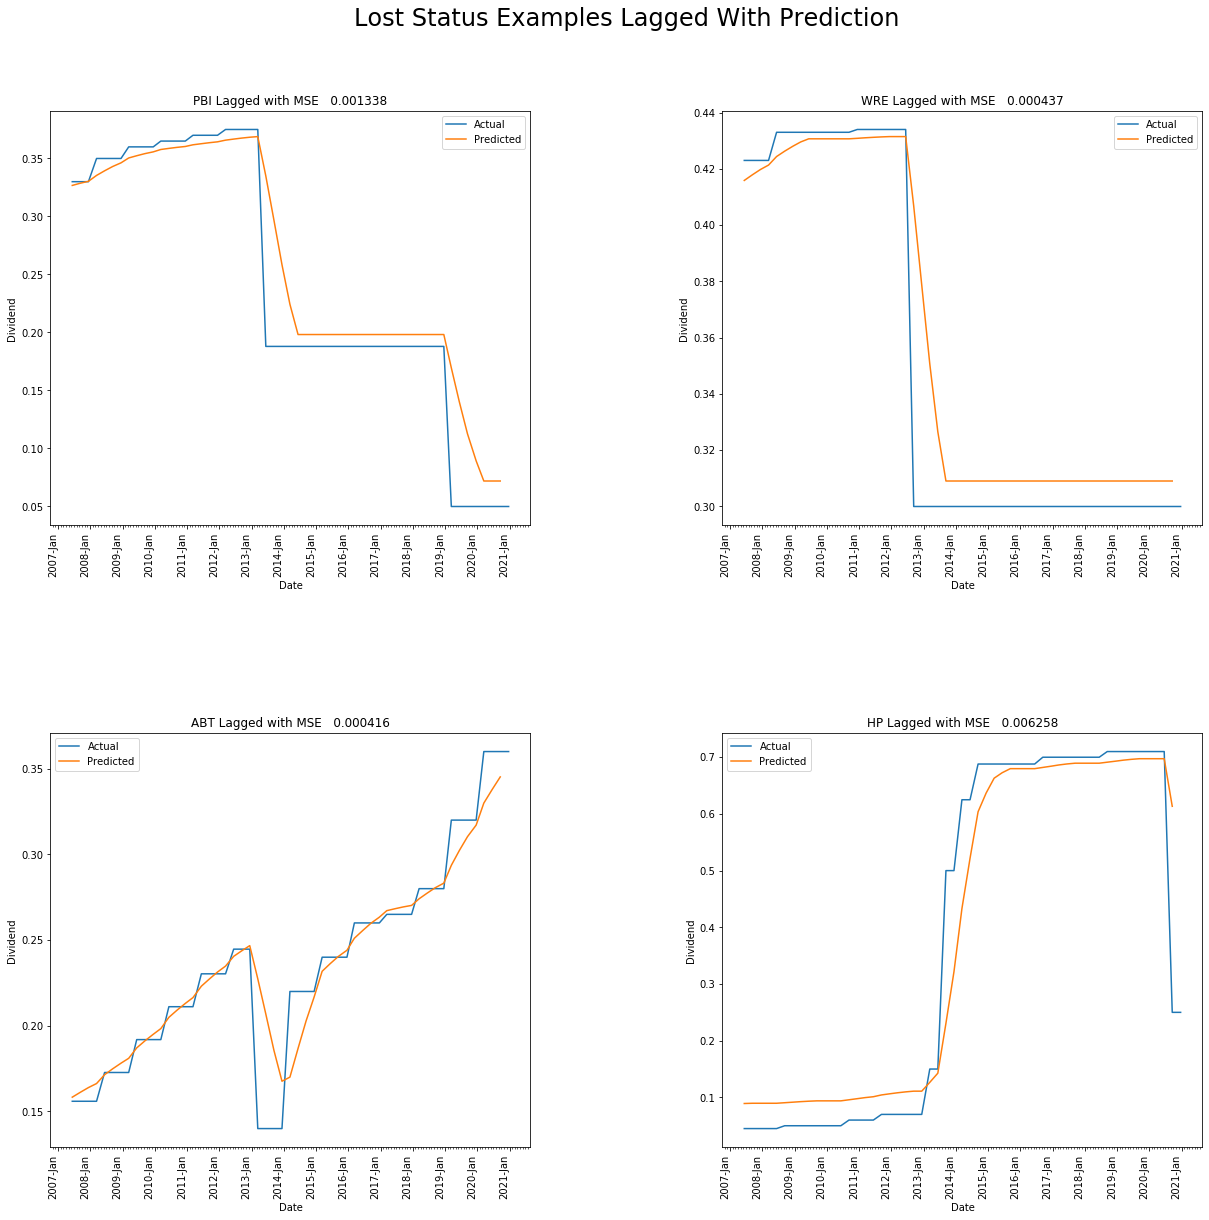

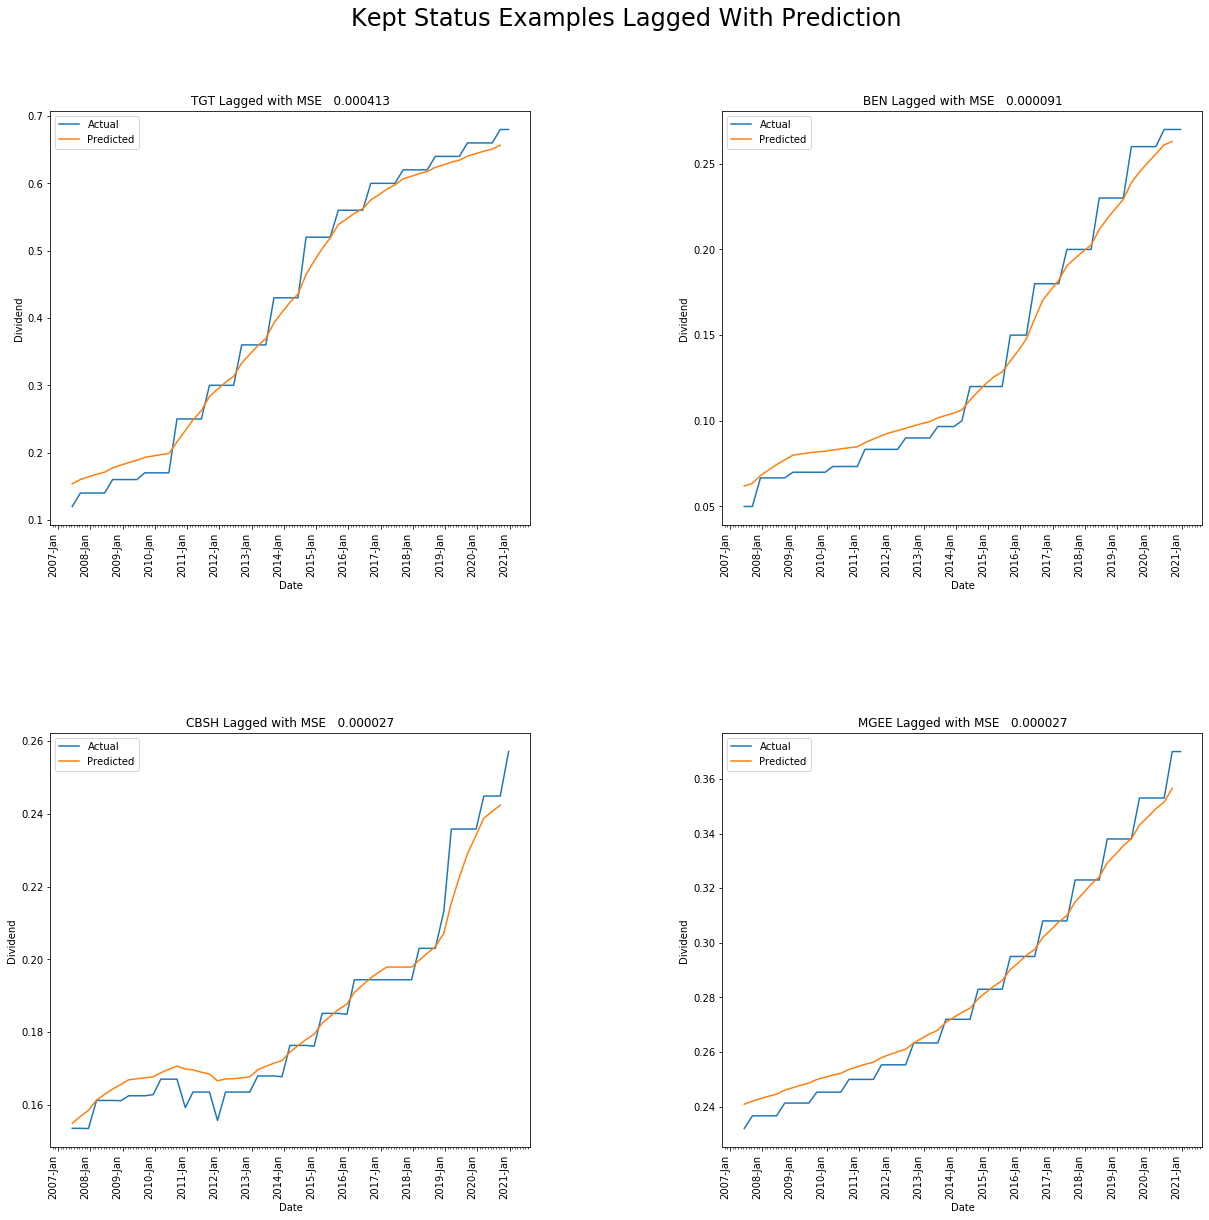

In [18]:
# Plot Prediction Results with MSE and added lag

time_index = df_new["WRE"]["Test"][overlap:].index

lost_ct = 0
kept_ct = 0

lag = -1

lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))        
lost_fig.suptitle("Lost Status Examples Lagged With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)


kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples Lagged With Prediction", fontsize=24)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

for i in stockListFix:
# def lagging(df, lag, time_index):
    df_pred = pd.Series(pred_result[i]["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(pred_result[i]["True"].reshape(-1), index=time_index)
        
    df_pred_lag = df_pred.shift(lag)
    
    mse_lag = mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag]))

    if i in lost_figs and lost_ct <= 3:

        np.save(f"../data/numpy/{i}_pred_lstm_lag", df_pred_lag.values)

        indx = lost_ct
        axs = lost_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
        axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_true)
        axs[indx].plot(df_pred_lag)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Actual", "Predicted"])
        axs[indx].set_title("{} Lagged with MSE {:10.6f}".format(i,mse_lag))
        extent = axs[indx].get_window_extent().transformed(lost_fig.dpi_scale_trans.inverted())
        lost_fig.savefig(f"./images/{i}_Prediction_lag.png", format="png", bbox_inches=extent.expanded(1.3, 1.35)) 
        lost_ct += 1

    if i in kept_figs and kept_ct <= 3:

        np.save(f"../data/numpy/{i}_pred_lstm_lag", df_pred_lag.values)

        indx = kept_ct
        axs = kept_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
        axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_true)
        axs[indx].plot(df_pred_lag)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Actual", "Predicted"])
        axs[indx].set_title("{} Lagged with MSE {:10.6f}".format(i,mse_lag))
        extent = axs[indx].get_window_extent().transformed(kept_fig.dpi_scale_trans.inverted())
        kept_fig.savefig(f"./images/{i}_Prediction_Lag.png", format="png", bbox_inches=extent.expanded(1.3, 1.35))     
        kept_ct += 1

plt.show()    

### As shown above, the model does a decent job of matching larger changes in the test data (i.e. sudden drops) which would be useful when determining whether the next dividend value is likely to fall. By incorporating a single sample lag, the accuracy increases even more.